# Implementation Paper Journal

# Multi-classification Assessment of Bank Personal Credit Risk Based on Multi-source Information Fusion

This notebook implements the methods described in the paper: 

"Multi-classification assessment of bank personal credit risk based on multi-source information fusion"

By Tianhui Wang, Renjing Liu, Guohua Qi

Reference: Expert Systems With Applications 191 (2022) 116236

# Introduction

The paper proposes a new multi-classification assessment model for personal credit risk based on the theory of information fusion (MIFCA) using six machine learning algorithms. The MIFCA model integrates the advantages of multiple classifiers and reduces the interference of uncertain information through Dempster-Shafer (D-S) evidence theory. The key contributions of the paper are:

- Constructing a new multi-classification credit assessment model to provide more accurate five-classification credit assessments compared to traditional binary classifications.

- Innovatively fusing six different types of classifiers using D-S evidence theory to reduce uncertainty and improve overall accuracy and robustness.

- Creating a model with fewer parameters to enhance efficiency and usability, suitable for big data applications

- Verifying the assessment performance of MIFCA on real datasets and comparing it with classic statistical and machine learning approaches.

# Objective

Our goal is to replicate the MIFCA model as described in the paper using the provided dataset. We will:

- Preprocess the data, handling missing values, outliers, and encoding categorical variables.

- Train six base classifiers: Decision Tree (DT), Random Forest (RF), Support Vector Machine (SVM), K-Nearest Neighbors (KNN), BP Neural Network (implemented as Multi-Layer Perceptron), and XGBoost.

- Implement Dempster-Shafer evidence theory to fuse the outputs of these classifiers.

- Evaluate the performance of the fused model and compare it with individual classifiers.

# Implementation

## Import Necessary Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For data preprocessing and model building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Machine Learning models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# For D-S evidence theory
from pyds import MassFunction

import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Preprocessing

### 1.1 Load the Dataset

Assuming your dataset is in the data folder and named `Dataset-Research.xlsx`

In [2]:
# Load the dataset
data = pd.read_excel('data/Dataset-Research.xlsx', header=1)

# Display the first few rows
data.head()

,Customer ID,Type of Loan Business,Guarantee the Balance,Account Connection Amount,Security Guarantee Amount,Five-level Classification,Whether Interest is Owed,Whether Self-service Loan,Type of Guarantee,Safety Coefficient,...,Whether Interest is Owed (regulatory standard),Repayment Type,Installment Repayment Method (numerical type),Installment Repayment Method (discrete type),Installment Repayment Cycle (numerical type),Repayment Cycle (discrete type),Number of Houses,Month Property Costs,Family Monthly Income,Five Categories
0,1,Personal Housing Mortgage Loan (First hand),850000.00,850000.00,85000000.0,A1,N,N,General Enterprise Guarantee,100.0,...,N,Payment by installments,2.0,Equal repayment of principal,M01,Month,1.0,343.84,15000.00,Normal
1,2,Personal Housing Mortgage Loan (First hand),2143810.46,2143810.46,171504836.8,A1,N,N,Average house,80.0,...,N,Payment by installments,1.0,Matching the principal and interest,M01,Month,1.0,342.55,19700.00,Normal
2,3,Personal Commercial Housing Mortgage Loan (Fir...,892500.00,892500.00,89250000.0,A1,N,N,General Enterprise Guarantee,100.0,...,N,Payment by installments,2.0,Equal repayment of principal,M01,Month,NaN,282.00,39678.00,Normal
3,4,Housing accumulation fund loan 3,NaN,NaN,NaN,A1,N,N,General Enterprise Guarantee,NaN,...,N,Payment by installments,1.0,Matching the principal and interest,M01,Month,NaN,NaN,3490.00,Normal
4,5,Personal Commercial Housing Mortgage Loan (Fir...,606400.45,606400.45,60640045.0,A1,N,N,Average house,100.0,...,N,Payment by installments,1.0,Matching the principal and interest,M01,Month,NaN,NaN,51502.56,Normal


### 1.2 Preliminary Exploration of Data Structures

In [3]:
# Check the shape of the dataset
print(f"The dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")

# List all columns
print("Columns in the dataset:")
print(data.columns.tolist())

The dataset contains 27522 rows and 28 columns.
Columns in the dataset:
['Customer ID', 'Type of Loan Business', 'Guarantee the Balance', 'Account Connection Amount', 'Security Guarantee Amount', 'Five-level Classification', 'Whether Interest is Owed', 'Whether Self-service Loan', 'Type of Guarantee', 'Safety Coefficient', 'Collateral Value (yuan)', 'Guarantee Method', 'Date Code', 'Approval Deadline', 'Whether Devalue Account', 'Industry Category', 'Down Payment Amount', 'Whether Personal Business Loan', 'Whether Interest is Owed (regulatory standard)', 'Repayment Type', 'Installment Repayment Method (numerical type)', 'Installment Repayment Method (discrete type)', 'Installment Repayment Cycle (numerical type)', 'Repayment Cycle (discrete type)', 'Number of Houses', 'Month Property Costs', 'Family Monthly Income', 'Five Categories']


### 1.3 Data Cleaning

#### 1.3.1 Remove Irrelevant or Redundant Variables

Based on the description, we need to drop certain columns that are either irrelevant or redundant.

In [4]:
# List of columns to drop
columns_to_drop = [
    'Customer ID',  # Irrelevant
    'Account Connection Amount',  # Redundant
    'Security Guarantee Amount',  # Redundant
    'Whether Interest is Owed',  # Duplicate information
    'Whether Self-service Loan',  # Only one value
    'Type of Guarantee',  # Duplicate with 'Guarantee Method'
    'Date Code',  # Duplicate with 'Approval Deadline'
    'Repayment Type',  # Similar to 'Installment Repayment Method'
    'Installment Repayment Cycle (numerical type)',  # Only one value
    'Repayment Cycle (discrete type)',  # Only one value
    'Industry Category',  # Too many missing values
    'Whether Personal Business Loan',  # Irrelevant
    'Installment Repayment Method (discrete type)'  # Duplicate with 'Installment Repayment Method (numerical type)'
]

# Drop the columns
data.drop(columns=columns_to_drop, inplace=True)

# Verify the remaining columns
print("Remaining columns after dropping:")
print(data.columns.tolist())

Remaining columns after dropping:
['Type of Loan Business', 'Guarantee the Balance', 'Five-level Classification', 'Safety Coefficient', 'Collateral Value (yuan)', 'Guarantee Method', 'Approval Deadline', 'Whether Devalue Account', 'Down Payment Amount', 'Whether Interest is Owed (regulatory standard)', 'Installment Repayment Method (numerical type)', 'Number of Houses', 'Month Property Costs', 'Family Monthly Income', 'Five Categories']


#### 1.3.2 Handle Missing Values

In [5]:
# Check for missing values
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
Type of Loan Business                                0
Guarantee the Balance                              304
Five-level Classification                            0
Safety Coefficient                                 304
Collateral Value (yuan)                            322
Guarantee Method                                   304
Approval Deadline                                    0
Whether Devalue Account                              0
Down Payment Amount                                620
Whether Interest is Owed (regulatory standard)       0
Installment Repayment Method (numerical type)      757
Number of Houses                                  4571
Month Property Costs                              1286
Family Monthly Income                               20
Five Categories                                      0
dtype: int64


Impute Missing Values

Since dropping all rows with missing values would significantly reduce the dataset size, we'll impute missing values.

In [6]:
# Impute Numerical Columns
# List of numerical columns with missing values
numerical_cols_with_na = ['Guarantee the Balance', 'Safety Coefficient', 'Collateral Value (yuan)', 
                          'Down Payment Amount', 'Number of Houses', 'Installment Repayment Method (numerical type)',
                          'Month Property Costs', 'Family Monthly Income']

# Impute numerical columns with mean
imputer_num = SimpleImputer(strategy='mean')
data[numerical_cols_with_na] = imputer_num.fit_transform(data[numerical_cols_with_na])

In [7]:
 # Impute Categorical Columns
 # List of categorical columns with missing values
categorical_cols_with_na = ['Guarantee Method']

# Impute categorical columns with mode
imputer_cat = SimpleImputer(strategy='most_frequent')
data[categorical_cols_with_na] = imputer_cat.fit_transform(data[categorical_cols_with_na])

In [8]:
# List of categorical columns with missing values
categorical_cols_with_na = ['Guarantee Method']

# Impute categorical columns with mode
imputer_cat = SimpleImputer(strategy='most_frequent')
data[categorical_cols_with_na] = imputer_cat.fit_transform(data[categorical_cols_with_na])


In [9]:
# Check for missing values after imputation
print("Missing values after imputation:")
print(data.isnull().sum())

Missing values after imputation:
Type of Loan Business                             0
Guarantee the Balance                             0
Five-level Classification                         0
Safety Coefficient                                0
Collateral Value (yuan)                           0
Guarantee Method                                  0
Approval Deadline                                 0
Whether Devalue Account                           0
Down Payment Amount                               0
Whether Interest is Owed (regulatory standard)    0
Installment Repayment Method (numerical type)     0
Number of Houses                                  0
Month Property Costs                              0
Family Monthly Income                             0
Five Categories                                   0
dtype: int64


#### 1.3.3 Handle Outliers

In [10]:
# Remove outliers in 'Month Property Costs' less than 20 or greater than 20000
data = data[(data['Month Property Costs'] >= 20) & (data['Month Property Costs'] <= 20000)]

# Remove outliers in 'Family Monthly Income' less than 1500
data = data[data['Family Monthly Income'] >= 1500]

# Reset index after dropping rows
data.reset_index(drop=True, inplace=True)

### 1.4 Data Transformation

We need to encode categorical variables into numerical ones.

In [11]:
# List of categorical variables to encode
categorical_vars = ['Type of Loan Business', 'Guarantee Method', 'Whether Devalue Account',
                    'Whether Interest is Owed (regulatory standard)', 'Five-level Classification', 'Five Categories']

# Use LabelEncoder for binary variables and OneHotEncoder for variables with more than two categories
label_encoder = LabelEncoder()

# Binary variables
binary_vars = ['Whether Devalue Account', 'Whether Interest is Owed (regulatory standard)']
for var in binary_vars:
    data[var] = label_encoder.fit_transform(data[var])

# For 'Five Categories', which is our target variable, encode it
data['Five Categories'] = label_encoder.fit_transform(data['Five Categories'])

# One-hot encode 'Type of Loan Business' and 'Guarantee Method'
data = pd.get_dummies(data, columns=['Type of Loan Business', 'Guarantee Method'], drop_first=True)

# Encode 'Five-level Classification' which seems to be related to risk levels
data['Five-level Classification'] = label_encoder.fit_transform(data['Five-level Classification'])


### 1.5 Data Splitting

Although the Pearson correlation coefficients are low to medium, we will keep all variables as they may contribute to the model.

In [12]:
# Separate features and target
X = data.drop('Five Categories', axis=1)
y = data['Five Categories']

### 1.6 Processing of Imbalanced Data Sets

#### 1.6.1 Check for Missing Values in X Before SMOTE

In [13]:
# Verify no missing values in features
print("Checking for missing values in features:")
print(X.isnull().sum().sum())

Checking for missing values in features:
0


#### 1.6.2 Proceed with SMOTE

In [14]:
# Split into training and test sets before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Check the distribution of target variable before SMOTE
print("Distribution of target variable before SMOTE:")
print(y_train.value_counts())

# Apply SMOTE to the training data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution after SMOTE
print("Distribution of target variable after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Distribution of target variable before SMOTE:
Five Categories
2    20321
3     1150
1      252
0       87
4       82
Name: count, dtype: int64
Distribution of target variable after SMOTE:
Five Categories
2    20321
3    20321
1    20321
0    20321
4    20321
Name: count, dtype: int64


### 1.7 Standardize Numerical Features

In [15]:
# Identify numerical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variable if present
if 'Five Categories' in numerical_cols:
    numerical_cols.remove('Five Categories')

# Standardize the numerical features
scaler = StandardScaler()
X_train_resampled[numerical_cols] = scaler.fit_transform(X_train_resampled[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

## 2. Train Base Classifiers

### 2.1 Decision Tree Classifier

In [16]:
# Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities
dt_probs = dt_model.predict_proba(X_test)

### 2.2 Random Forest Classifier

In [17]:
# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities
rf_probs = rf_model.predict_proba(X_test)

### 2.3 Support Vector Machine

In [18]:
# Train SVM
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities
svm_probs = svm_model.predict_proba(X_test)

### 2.4 K-Nearest Neighbors

In [19]:
# Train KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities
knn_probs = knn_model.predict_proba(X_test)

### 2.5 BP Neural Network (MLPClassifier)

In [20]:
# Train BP Neural Network
bp_model = MLPClassifier(random_state=42, max_iter=300)
bp_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities
bp_probs = bp_model.predict_proba(X_test)

### 2.6 XGBoost Classifier

In [21]:
# Train XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities
xgb_probs = xgb_model.predict_proba(X_test)

## 3. D-S Evidence Theory Fusion

### 3.1 Prepare Belief Assignments

In [22]:
# Number of classes
classes = dt_model.classes_
num_classes = len(classes)

# Initialize list to store mass functions for each classifier
mass_functions_list = []

# List of probabilities from classifiers
probs_list = [dt_probs, rf_probs, svm_probs, knn_probs, bp_probs, xgb_probs]

# For each classifier, create mass functions for each instance
for probs in probs_list:
    mass_functions = []
    for prob in probs:
        mass = {}
        for i, cls in enumerate(classes):
            mass[str(cls)] = prob[i]
        mass_functions.append(MassFunction(mass))
    mass_functions_list.append(mass_functions)

### 3.2 Combine Mass Functions Using Dempster's Rule

In [23]:
# Install tqdm for progress bar if not already installed
!pip install tqdm

In [25]:
from tqdm import tqdm

# Initialize list to store fused predictions
fused_predictions = []

# Iterate over each instance
for i in tqdm(range(len(X_test))):
    # Get the mass functions for the ith instance from all classifiers
    mass_functions = [mass_functions_list[j][i] for j in range(len(mass_functions_list))]
    
    # Combine the mass functions using Dempster's rule
    combined_mass = mass_functions[0]
    for mf in mass_functions[1:]:
        combined_mass = combined_mass & mf  # Dempster's combination
    
    # Decide the class with the highest belief
    predicted_class_set = combined_mass.max_pl()
    predicted_class = int(list(predicted_class_set)[0])
    fused_predictions.append(predicted_class)

100%|██████████| 5474/5474 [00:00<00:00, 7365.87it/s]


## 4. Evaluation of the Model's Performance

### 4.1 Evaluate Base Classifiers

In [26]:
# Function to evaluate and print metrics
def evaluate_model(model_name, y_true, y_pred):
    print(f"Performance of {model_name}:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro', zero_division=0))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro', zero_division=0))
    print("F1-score (macro):", f1_score(y_true, y_pred, average='macro', zero_division=0))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("-" * 60)

# Predictions from base classifiers
dt_pred = dt_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
svm_pred = svm_model.predict(X_test)
knn_pred = knn_model.predict(X_test)
bp_pred = bp_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Evaluate each model
evaluate_model("Decision Tree", y_test, dt_pred)
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("SVM", y_test, svm_pred)
evaluate_model("KNN", y_test, knn_pred)
evaluate_model("BP Neural Network", y_test, bp_pred)
evaluate_model("XGBoost", y_test, xgb_pred)

Performance of Decision Tree:
Accuracy: 0.9985385458531238
Precision (macro): 0.9945762711864408
Recall (macro): 0.9272727272727274
F1-score (macro): 0.9528064146620847

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        22
           1       1.00      1.00      1.00        63
           2       1.00      1.00      1.00      5081
           3       0.97      1.00      0.99       287
           4       1.00      1.00      1.00        21

    accuracy                           1.00      5474
   macro avg       0.99      0.93      0.95      5474
weighted avg       1.00      1.00      1.00      5474

------------------------------------------------------------
Performance of Random Forest:
Accuracy: 0.9983558640847643
Precision (macro): 0.9939189189189189
Recall (macro): 0.9181818181818182
F1-score (macro): 0.9454839500122519

Classification Report:
              precision    recall  f1-score   support

         

### 4.2 Evaluate the MIFCA Model

In [27]:
# Evaluate the fused model
evaluate_model("MIFCA Model", y_test, fused_predictions)

Performance of MIFCA Model:
Accuracy: 0.9983558640847643
Precision (macro): 0.9690770092316047
Recall (macro): 0.9446789566825473
F1-score (macro): 0.9517207645894358

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        22
           1       0.98      1.00      0.99        63
           2       1.00      1.00      1.00      5081
           3       0.99      1.00      0.99       287
           4       0.88      1.00      0.93        21

    accuracy                           1.00      5474
   macro avg       0.97      0.94      0.95      5474
weighted avg       1.00      1.00      1.00      5474

------------------------------------------------------------


### 4.3 Confusion Matrix Heat Maps

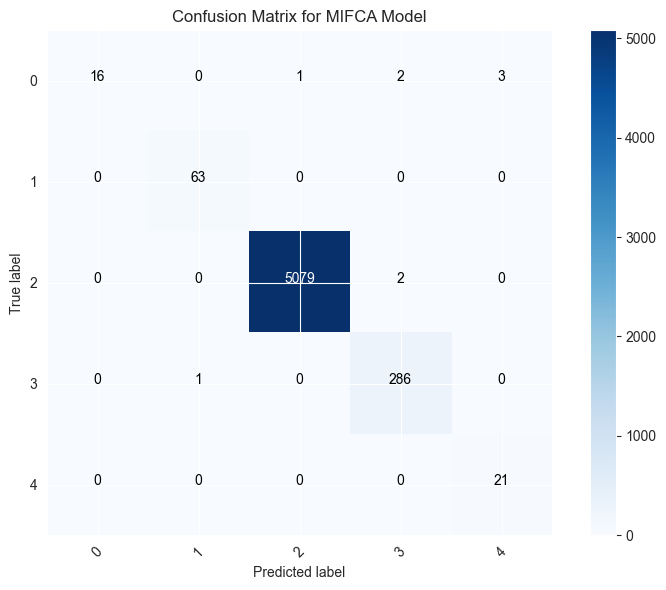

In [28]:
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    class_names = [str(cls) for cls in classes]
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Confusion matrix for MIFCA model
cm = confusion_matrix(y_test, fused_predictions)
plot_confusion_matrix(cm, classes=classes, title='Confusion Matrix for MIFCA Model')

## 5. Conclusion